In [1]:
import os
import pandas as pd
import numpy as np


main_publisher = 'Merged'

script_dir = os.path.dirname(os.path.realpath('__file__'))
path = os.path.join(script_dir, '../Data/' + main_publisher + '/')

df_chapters = pd.read_csv(path + 'chapters.csv', delimiter = '|')
df_chapters_embeddings = pd.read_csv(path + 'embeddings_chapters.csv', delimiter = '|', index_col=0)
df_concepts = pd.read_csv(path + 'concepts_bis.csv', delimiter = '|')
df_concepts_embeddings = pd.read_csv(path + 'embeddings_concepts_bis.csv', delimiter = '|', index_col=0)
df_classes = pd.read_csv(path + 'classes_bis.csv', delimiter = '|')
df_classes_embeddings = pd.read_csv(path + 'embeddings_classes_bis.csv', delimiter = '|', index_col=0)
df_precedences_episodes = pd.read_csv(path + 'precedences_episodes.csv', delimiter = '|')
df_precedences_series = pd.read_csv(path + 'precedences_series.csv', delimiter = '|')

df_concepts['Concept'] = df_concepts['Concept'].apply(lambda x : x.split('/')[-1])

df_classes = df_classes.dropna()
print(f'{df_chapters["Cid"].isna().sum().sum():04d} NaN values in chapters.')
print(f'{df_concepts.isna().sum().sum():04d} Nan values in concepts.')
print(f'{df_classes.isna().sum().sum():04d} Nan values in classes.')
print(f'{df_precedences_episodes.isna().sum().sum():04d} Nan values in episdes precedences.')
print(f'{df_precedences_series.isna().sum().sum():04d} Nan values in series precedences.')

0000 NaN values in chapters.
0000 Nan values in concepts.
0000 Nan values in classes.
0000 Nan values in episdes precedences.
0000 Nan values in series precedences.


In [2]:
from utils import *

unique_oer_id = id_mapper(df_chapters['Cid'], 'OER')
unique_concept_id =  id_mapper(df_concepts['Concept'], 'Concept')
unique_class_id =  id_mapper(df_classes['Class'], 'Class')

In [3]:
oer_covers_concept_subject = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'mappedID', 
                                       how = 'left', right_on = 'OER')
oer_covers_concept_pr = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'PR', 
                                          how = 'right', right_on = 'OER')
oer_covers_concept_object = edge_construction(df1 = df_concepts, df2 = unique_concept_id, col = 'mappedID', 
                                       how = 'left', right_on = 'Concept')

oer_before_oer_ep_subject = edge_construction(df1 = df_precedences_episodes, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_ep_object = edge_construction(df1 = df_precedences_episodes, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')
oer_before_oer_sr_subject = edge_construction(df1 = df_precedences_series, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_sr_object = edge_construction(df1 = df_precedences_series, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')

concept_belongs_class_subject = edge_construction(df1 = df_classes, df2 = unique_concept_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Concept', right_on = 'Concept')
concept_belongs_class_object = edge_construction(df1 = df_classes, df2 = unique_class_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Class', right_on = 'Class')

oer_covers_concept = torch.stack([oer_covers_concept_subject, oer_covers_concept_object], dim = 0).long()
oer_covers_concept_rev = torch.stack([oer_covers_concept_object, oer_covers_concept_subject], dim = 0).long()
oer_before_oer_ep = torch.stack([oer_before_oer_ep_subject, oer_before_oer_ep_object], dim = 0).long()
oer_before_oer_sr = torch.stack([oer_before_oer_sr_subject, oer_before_oer_sr_object], dim = 0).long()
concept_belongs_class = torch.stack([concept_belongs_class_subject, concept_belongs_class_object], dim = 0).long()
concept_belongs_class_rev = torch.stack([concept_belongs_class_object, concept_belongs_class_subject], dim = 0).long()
print(oer_covers_concept.shape)
print(oer_covers_concept_rev.shape)
print(oer_before_oer_ep.shape)
print(oer_before_oer_sr.shape)
print(concept_belongs_class.shape)
print(concept_belongs_class_rev.shape)

torch.Size([2, 24347])
torch.Size([2, 24347])
torch.Size([2, 2928])
torch.Size([2, 1407])
torch.Size([2, 72048])
torch.Size([2, 72048])


In [4]:
chapters_embeddings_tmp = {}
concepts_embeddings_tmp = {} 
classes_embeddings_tmp = {}

chapters_r = range(len(df_chapters['Cid'].unique()))
concepts_c = range(len(df_concepts['Concept'].unique()))
classes_c = range(len(df_classes['Class'].unique()))

chapters_embeddings = np.zeros(shape=(len(chapters_r), 768))
concepts_embeddings = np.zeros(shape=(len(concepts_c), 768))
classes_embeddings = np.zeros(shape=(len(classes_c), 768))


i = 0
for r in chapters_r:
    chapters_embeddings_tmp[r] = list(filter(None, df_chapters_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    chapters_embeddings_tmp[r] = [float(f) for f in chapters_embeddings_tmp[r]]
    for a in range(len(chapters_embeddings_tmp[r])):
            chapters_embeddings[i][a] = chapters_embeddings_tmp[r][a]
    i += 1

i = 0
for r in concepts_c:
    concepts_embeddings_tmp[r] = list(filter(None, df_concepts_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    concepts_embeddings_tmp[r] = [float(f) for f in concepts_embeddings_tmp[r]]
    for a in range(len(concepts_embeddings_tmp[r])):
            concepts_embeddings[i][a] = concepts_embeddings_tmp[r][a]
    i += 1   

i = 0
for r in classes_c:
    classes_embeddings_tmp[r] = list(filter(None, df_classes_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    classes_embeddings_tmp[r] = [float(f) for f in classes_embeddings_tmp[r]]
    for a in range(len(classes_embeddings_tmp[r])):
            classes_embeddings[i][a] = classes_embeddings_tmp[r][a]
    i += 1

chapters_embeddings = torch.from_numpy(chapters_embeddings).to(torch.float32)
concepts_embeddings = torch.from_numpy(concepts_embeddings).to(torch.float32)
classes_embeddings = torch.from_numpy(classes_embeddings).to(torch.float32)

In [5]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data['OER'].node_id = torch.tensor(unique_oer_id['mappedID'].values)
data['OER'].x = chapters_embeddings
data['Concept'].node_id = torch.tensor(unique_concept_id['mappedID'].values)
data['Concept'].x = concepts_embeddings
data['Class'].node_id = torch.tensor(unique_class_id['mappedID'].values)
data['Class'].x = classes_embeddings
data['OER', 'covers', 'Concept'].edge_index = oer_covers_concept
data['Concept', 'rev_covers', 'OER'].edge_index = oer_covers_concept_rev

data['OER', 'covers', 'Concept'].edge_attr = oer_covers_concept_pr
print(oer_before_oer_ep.shape)
data['OER', 'before_sr', 'OER'].edge_index = oer_before_oer_sr
data['OER', 'before_ep', 'OER'].edge_index = oer_before_oer_ep
data['Concept', 'belongs', 'Class'].edge_index = concept_belongs_class
data['Class', 'rev_belongs', 'Concept'].edge_index = concept_belongs_class_rev

#data = T.ToUndirected()(data)
data.validate()
print(data)

/home/abazouzi/Documents/Code/PrerequisiteLearning/clara-datasets/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2, 2928])
HeteroData(
  OER={
    node_id=[4407],
    x=[4407, 768]
  },
  Concept={
    node_id=[7970],
    x=[7970, 768]
  },
  Class={
    node_id=[302],
    x=[302, 768]
  },
  (OER, covers, Concept)={
    edge_index=[2, 24347],
    edge_attr=[24732]
  },
  (Concept, rev_covers, OER)={ edge_index=[2, 24347] },
  (OER, before_sr, OER)={ edge_index=[2, 1407] },
  (OER, before_ep, OER)={ edge_index=[2, 2928] },
  (Concept, belongs, Class)={ edge_index=[2, 72048] },
  (Class, rev_belongs, Concept)={ edge_index=[2, 72048] }
)


In [6]:
agnostic = False
if agnostic:
    num_val = 0.5
    num_test = 0.5
else:
    num_val = 0.15
    num_test = 0.15
transform = T.RandomLinkSplit(
    num_val = num_val,
    num_test = num_test,
    disjoint_train_ratio = 0.5,
    neg_sampling_ratio = 1.0,
    add_negative_train_samples = True,
    edge_types=('OER', 'before_sr', 'OER')
)

train_data, val_data, test_data = transform(data)
print(f'{len(train_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for training')
print(f'{len(val_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for validation')
print(f'{len(test_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for testing')

984	 Edges for training
422	 Edges for validation
422	 Edges for testing


In [7]:
hidden_channels = [16, 32, 64, 128]
num_layers = [1, 2, 4, 6]
epochs = [50, 100, 150, 200]
learning_rates = [0.001, 0.01, 0.1]
entity_features = 768

parameters = [{
    "epochs" : e,
    "hidden_channels" : h,
    "num_layers" : n,
    "lr" : l,
    "entity_features" : entity_features
} for h in hidden_channels
    for l in learning_rates
    for n in num_layers
    for e in epochs]

assert len(parameters) == len(hidden_channels) * len(num_layers) * len(epochs) * len(learning_rates), "ERROR constructing parameters variable"
print("Number of parameter combinations : ", len(parameters))

Number of parameter combinations :  192


In [8]:
from models import *
import torch

df_results = pd.DataFrame()

for params in parameters:
    results = {}

    model = Modelv7(node_types = data.node_types, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
    train_results = train(model, train_data, params['epochs'], params['lr'])
    model = train_results['Model']
    results['Epochs'] = params['epochs']
    results['Learning rate'] = params['lr']
    results['Layers'] = params['num_layers']
    results['Channels'] = params['hidden_channels']

    validation_results = predict(model, val_data)
    results['Validation AUC'] = validation_results["AUC"]
    results['Validation Precision'] = validation_results["Precision"]
    results['Validation Accuracy'] = validation_results["Accuracy"]
    results['Validation F1'] = validation_results["F1"]

    test_results = predict(model, test_data)
    results['Test AUC'] = test_results["AUC"]
    results['Test Precision'] = test_results["Precision"]
    results['Test Accuracy'] = test_results["Accuracy"]
    results['Test F1'] = test_results["F1"]

    loss_values = train_results['Loss_values']
    results['Loss'] = train_results['Loss']
    results['Duration'] = train_results['Duration']
    df_results = pd.concat([df_results, pd.DataFrame([results])], ignore_index = True)

v = 'v7'
if agnostic :
    v = 'Agnostic/' + v
else :
    v = 'Informed/' + v
df_results.to_csv(f'../Output/Evaluation/{v}.csv', index = False, sep = '|')

In [9]:
from models import *
import torch

df_results = pd.DataFrame()

for params in parameters:
    results = {}

    model = Modelv6(node_types = data.node_types, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
    train_results = train(model, train_data, params['epochs'], params['lr'])
    model = train_results['Model']
    results['Epochs'] = params['epochs']
    results['Learning rate'] = params['lr']
    results['Layers'] = params['num_layers']
    results['Channels'] = params['hidden_channels']

    validation_results = predict(model, val_data)
    results['Validation AUC'] = validation_results["AUC"]
    results['Validation Precision'] = validation_results["Precision"]
    results['Validation Accuracy'] = validation_results["Accuracy"]
    results['Validation F1'] = validation_results["F1"]

    test_results = predict(model, test_data)
    results['Test AUC'] = test_results["AUC"]
    results['Test Precision'] = test_results["Precision"]
    results['Test Accuracy'] = test_results["Accuracy"]
    results['Test F1'] = test_results["F1"]

    loss_values = train_results['Loss_values']
    results['Loss'] = train_results['Loss']
    results['Duration'] = train_results['Duration']
    df_results = pd.concat([df_results, pd.DataFrame([results])], ignore_index = True)

v = 'v6'
if agnostic:
    v = 'Agnostic/' + v
else :
    v = 'Informed/' + v
df_results.to_csv(f'../Output/Evaluation/{v}.csv', index = False, sep = '|')

In [23]:
df_results = pd.DataFrame()

for params in parameters:
    results = {}

    model = Modelv8(node_types = data.node_types, heads = 2, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
    train_results = train(model, train_data, params['epochs'], params['lr'])
    model = train_results['Model']
    results['Epochs'] = params['epochs']
    results['Learning rate'] = params['lr']
    results['Layers'] = params['num_layers']
    results['Channels'] = params['hidden_channels']

    validation_results = predict(model, val_data)
    results['Validation AUC'] = validation_results["AUC"]
    results['Validation Precision'] = validation_results["Precision"]
    results['Validation Accuracy'] = validation_results["Accuracy"]
    results['Validation F1'] = validation_results["F1"]

    test_results = predict(model, test_data)
    results['Test AUC'] = test_results["AUC"]
    results['Test Precision'] = test_results["Precision"]
    results['Test Accuracy'] = test_results["Accuracy"]
    results['Test F1'] = test_results["F1"]

    loss_values = train_results['Loss_values']
    results['Loss'] = train_results['Loss']
    results['Duration'] = train_results['Duration']
    df_results = pd.concat([df_results, pd.DataFrame([results])], ignore_index = True)

v = 'v8'
if agnostic:
    v = 'Agnostic/' + v
else :
    v = 'Informed/' + v
df_results.to_csv(f'../Output/Evaluation/{v}.csv', index = False, sep = '|')

In [9]:
from models import *
df_results = pd.DataFrame()

for params in parameters:
    results = {}

    model = Modelv8(node_types = data.node_types, heads = 4, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
    train_results = train(model, train_data, params['epochs'], params['lr'])
    model = train_results['Model']
    results['Epochs'] = params['epochs']
    results['Learning rate'] = params['lr']
    results['Layers'] = params['num_layers']
    results['Channels'] = params['hidden_channels']

    validation_results = predict(model, val_data)
    results['Validation AUC'] = validation_results["AUC"]
    results['Validation Precision'] = validation_results["Precision"]
    results['Validation Accuracy'] = validation_results["Accuracy"]
    results['Validation F1'] = validation_results["F1"]

    test_results = predict(model, test_data)
    results['Test AUC'] = test_results["AUC"]
    results['Test Precision'] = test_results["Precision"]
    results['Test Accuracy'] = test_results["Accuracy"]
    results['Test F1'] = test_results["F1"]

    loss_values = train_results['Loss_values']
    results['Loss'] = train_results['Loss']
    results['Duration'] = train_results['Duration']
    df_results = pd.concat([df_results, pd.DataFrame([results])], ignore_index = True)

v = 'v9'
if agnostic:
    v = 'Agnostic/' + v
else :
    v = 'Informed/' + v
df_results.to_csv(f'../Output/Evaluation/{v}.csv', index = False, sep = '|')

In [43]:
hidden_channels_selected = 128
entity_features = 768
num_layers_selected = 4
epochs_selected = 100
learning_rates_selected = 0.01

selected_params = [{
    'epochs': 250, 
    'hidden_channels': 128, 
    'num_layers': 6, #8 is too much => generated NaN values in node attributes
    'lr': 0.1, 
    'entity_features': 768
}]

In [273]:
v = 'v1'
df_results_show = pd.read_csv(f'../Output/Evaluation/{v}.csv', delimiter = '|')
df_results_show.head()

,Epochs,Learning rate,Layers,Channels,Test Accuracy,Validation AUC,Validation Precision,Validation Accuracy,Test AUC,Test Precision,Loss,Duration
0,50,0.01,4,64,0.523356,0.543541,0.636036,0.543541,0.523356,0.574312,38.131276,18.124463
1,100,0.01,4,64,0.525087,0.539216,0.561706,0.539216,0.525087,0.540018,70.603519,35.687492
2,200,0.01,4,64,0.514706,0.527105,0.524737,0.527105,0.514706,0.513615,135.349959,75.539184
3,50,0.01,8,64,0.521050,0.542676,0.604520,0.542676,0.521050,0.554723,46.879290,38.534052
4,100,0.01,8,64,0.524221,0.544983,0.588636,0.544983,0.524221,0.553030,80.719926,83.398478


<function matplotlib.pyplot.show(close=None, block=None)>

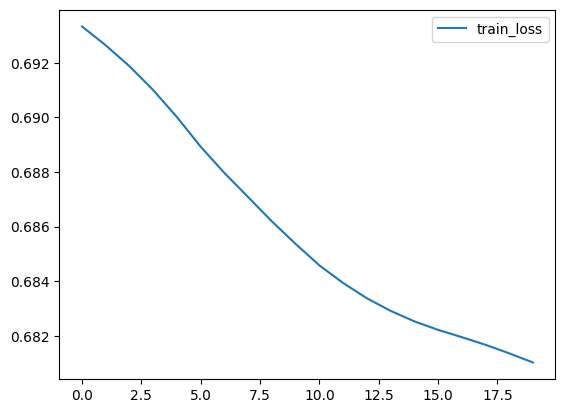

In [134]:
from matplotlib import pyplot as plt

plt.plot(loss_values, label='train_loss')
plt.legend()
plt.show

Validation AUC : 0.5027
Validation Precision : 0.8571
Validation Accuracy : 0.5029


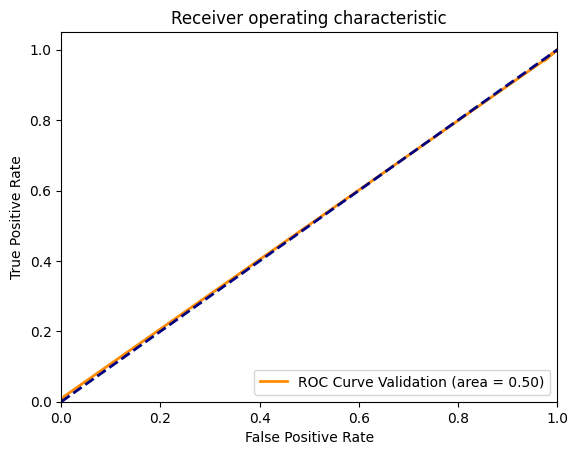

In [170]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, roc_curve, auc

preds = model(val_data).detach().numpy()
preds_labels = (preds > 0.5) * 1
ground_truths = val_data["OER", "before", "OER"].edge_label.detach().numpy()
auc_score = roc_auc_score(ground_truths, preds)
print(f"Validation AUC : {auc_score:.4f}")
results['Validation AUC'] = auc_score
precision = precision_score(ground_truths, preds_labels)
print(f"Validation Precision : {precision:.4f}")
results['Validation Precision'] = precision
accuracy = accuracy_score(ground_truths, preds_labels)
print(f"Validation Accuracy : {accuracy:.4f}")
results['Validation Accuracy'] = accuracy

fpr, tpr, thresholds = roc_curve(ground_truths, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC Curve Validation (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

TEST AUC : 0.6256
TEST Precision : 0.5987
TEST Accuracy : 0.5779


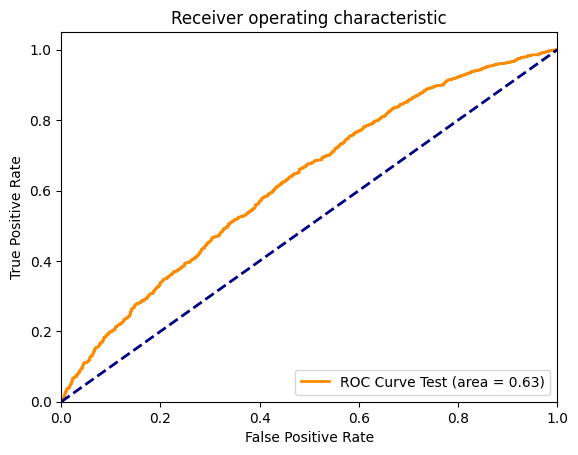

In [107]:
preds = model(test_data).detach().numpy()
preds_labels = (preds > 0.5) * 1
ground_truths = test_data["OER", "before", "OER"].edge_label.detach().numpy()
auc_score = roc_auc_score(ground_truths, preds)
print(f"TEST AUC : {auc_score:.4f}")
results['Test AUC'] = auc_score
precision = precision_score(ground_truths, preds_labels)
print(f"TEST Precision : {precision:.4f}")
results['Test Precision'] = precision
accuracy = accuracy_score(ground_truths, preds_labels)
print(f"TEST Accuracy : {accuracy:.4f}")
results['Test Accuracy'] = accuracy
fpr, tpr, thresholds = roc_curve(ground_truths, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC Curve Test (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [108]:
df_results.head()

,Epochs,Learning rate,Loss,Duration,Validation AUC,Validation Precision,Validation Accuracy,Test AUC,Test Precision,Test Accuracy
0,200,0.001,118.437324,64.649032,0.616882,0.595824,0.574106,0.625591,0.598684,0.577855
